# IMPORT NECESSARY LIBRARY

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import requests
import json
import string
import matplotlib.pyplot as plt
import seaborn as sns

# READ DATA

***Data mình down thẳng từ github của chị Kim xuống***
- Link GitHub: https://github.com/kimkim00/UIT-ViSD4SA





In [ ]:
WORKING_DIR="/content/drive/MyDrive/WORK SPACE/TERM 6/CS338 - NHẬN DẠNG/"

In [ ]:
train_url="https://raw.githubusercontent.com/kimkim00/UIT-ViSD4SA/main/data/train.jsonl"
test_url="https://raw.githubusercontent.com/kimkim00/UIT-ViSD4SA/main/data/test.jsonl"
dev_url="https://raw.githubusercontent.com/kimkim00/UIT-ViSD4SA/main/data/dev.jsonl"

In [ ]:
response = requests.get(train_url)
data = response.text
# Chuyển đổi dữ liệu thành danh sách các đối tượng
train_list = []
lines = data.split('\n')
for line in lines:
    if line:
        # Phân tích cú pháp dòng thành đối tượng JSON
        json_obj = json.loads(line)
        train_list.append(json_obj)
print("số lượng train_data:",len(train_list))

số lượng train_data: 7785


In [ ]:
response = requests.get(test_url)
data = response.text
# Chuyển đổi dữ liệu thành danh sách các đối tượng
test_list = []
lines = data.split('\n')
for line in lines:
    if line:
        # Phân tích cú pháp dòng thành đối tượng JSON
        json_obj = json.loads(line)
        test_list.append(json_obj)
print("số lượng test_data:",len(test_list))

số lượng test_data: 2225


In [ ]:
response = requests.get(dev_url)
data = response.text
# Chuyển đổi dữ liệu thành danh sách các đối tượng
dev_list = []
lines = data.split('\n')
for line in lines:
    if line:
        # Phân tích cú pháp dòng thành đối tượng JSON
        json_obj = json.loads(line)
        dev_list.append(json_obj)
print("số lượng dev_data:",len(dev_list))

số lượng dev_data: 1112


In [ ]:
dev_list[1]

{'text': 'Mục đích mình sài thì cũng ok, đau là mới mua được 1 tháng giá đã giảm đi triệu 🤮🤮🤮',
 'labels': [[9, 29, 'GENERAL#POSITIVE'], [31, 79, 'SER&ACC#NEGATIVE']]}

# PROCESSING


## aspect

In [ ]:
def preprocess_aspect(data):
    processed_data = []

    for sample in data:
        text = sample['text']
        labels = sample['labels']

        words = []
        word_indices = []  # Lưu chỉ số bắt đầu của mỗi từ

        current_word = ""
        for i, char in enumerate(text):
            if char in string.punctuation or char.isspace():
                if current_word:
                    words.append(current_word)
                    word_indices.append(i - len(current_word))
                    current_word = ""
                if not char.isspace():
                    words.append(char)
                    word_indices.append(i)
            else:
                current_word += char

        if current_word:
            words.append(current_word)
            word_indices.append(len(text) - len(current_word))

        # Khởi tạo danh sách nhãn và danh sách từ được gán nhãn
        label_seq = ['O'] * len(words)
        word_seq = words

        # Gán nhãn theo dạng B-<aspect> I-<aspect> O
        for label in labels:
            start_char_index = label[0]
            end_char_index = label[1]
            aspect, sentiment = label[2].split('#')

            # Tìm chỉ số từ tương ứng với chỉ số kí tự
            start_word_index = find_word_index(start_char_index, word_indices)
            end_word_index = find_word_index(end_char_index, word_indices)

            if start_word_index is not None and end_word_index is not None:
                # Gán nhãn B-<aspect> cho từ đầu tiên trong khía cạnh
                label_seq[start_word_index] = 'B-{}'.format(aspect)

                # Gán nhãn I-<aspect> cho các từ tiếp theo trong khía cạnh
                for i in range(start_word_index + 1, end_word_index + 1):
                    label_seq[i] = 'I-{}'.format(aspect)

        processed_data.append((word_seq, label_seq))

    return processed_data

def find_word_index(char_index, word_indices):
    for i, index in enumerate(word_indices):
        if char_index >= index and (i == len(word_indices) - 1 or char_index < word_indices[i+1]):
            return i
    return None

# Ví dụ sử dụng


In [ ]:
processed_data

điền lần lượt train, test, dev vào các ô lệnh dưới đây

In [ ]:
processed_data = preprocess_aspect(dev_list) #THAY Ở ĐÂY

In [ ]:
processed_data[1]

(['Mục',
  'đích',
  'mình',
  'sài',
  'thì',
  'cũng',
  'ok',
  ',',
  'đau',
  'là',
  'mới',
  'mua',
  'được',
  '1',
  'tháng',
  'giá',
  'đã',
  'giảm',
  'đi',
  'triệu',
  '🤮🤮🤮'],
 ['O',
  'O',
  'B-GENERAL',
  'I-GENERAL',
  'I-GENERAL',
  'I-GENERAL',
  'I-GENERAL',
  'I-GENERAL',
  'B-SER&ACC',
  'I-SER&ACC',
  'I-SER&ACC',
  'I-SER&ACC',
  'I-SER&ACC',
  'I-SER&ACC',
  'I-SER&ACC',
  'I-SER&ACC',
  'I-SER&ACC',
  'I-SER&ACC',
  'I-SER&ACC',
  'I-SER&ACC',
  'O'])

In [ ]:
processed_data_filtered = []
for word_seq, label_seq in processed_data:
    if len(word_seq) <= 120 and len(label_seq) <= 120:
        processed_data_filtered.append((word_seq, label_seq))

# Tạo danh sách rỗng cho từng cột
ids = []
words = []
bio = []

# Duyệt qua danh sách dữ liệu và tách thành các cột tương ứng
for i, (sentence, labels) in enumerate(processed_data_filtered):
    # Lấy chiều dài câu
    sentence_length = len(sentence)

    # Thêm ID cho câu
    ids.extend([i] * sentence_length)

    # Thêm từ và BIO cho câu
    words.extend(sentence)
    bio.extend(labels)

# Tạo DataFrame từ các cột đã tách
df = pd.DataFrame({'sentence_id': ids, 'words': words, 'labels': bio})

# In DataFrame
print(df)


       sentence_id  words         labels
0                0   Chơi  B-PERFORMANCE
1                0   game  I-PERFORMANCE
2                0  người  I-PERFORMANCE
3                0     ta  I-PERFORMANCE
4                0    bắn  I-PERFORMANCE
...            ...    ...            ...
42339         1093    xin              O
42340         1093    hỏi              O
42341         1093     vì              O
42342         1093    sao              O
42343         1093      ?              O

[42344 rows x 3 columns]


In [ ]:
df.to_csv(WORKING_DIR+"ĐỒ ÁN /DATA/ASPECT/aspect_TRAIN.csv",index=False)

In [ ]:
df.to_csv(WORKING_DIR+"ĐỒ ÁN /DATA/ASPECT/aspect_TEST.csv",index=False)

In [ ]:
df.to_csv(WORKING_DIR+"ĐỒ ÁN /DATA/ASPECT/aspect_DEV.csv",index=False)

## sentiment

In [ ]:
def preprocess_sentiment(data):
    processed_data = []

    for sample in data:
        text = sample['text']
        labels = sample['labels']

        words = []
        word_indices = []  # Lưu chỉ số bắt đầu của mỗi từ

        current_word = ""
        for i, char in enumerate(text):
            if char in string.punctuation or char.isspace():
                if current_word:
                    words.append(current_word)
                    word_indices.append(i - len(current_word))
                    current_word = ""
                if not char.isspace():
                    words.append(char)
                    word_indices.append(i)
            else:
                current_word += char

        if current_word:
            words.append(current_word)
            word_indices.append(len(text) - len(current_word))

        # Khởi tạo danh sách nhãn và danh sách từ được gán nhãn
        label_seq = ['O'] * len(words)
        word_seq = words

        # Gán nhãn theo dạng BIO-Sentiment
        for label in labels:
            start_char_index = label[0]
            end_char_index = label[1]
            aspect, sentiment = label[2].split('#')

            # Tìm chỉ số từ tương ứng với chỉ số kí tự
            start_word_index = find_word_index(start_char_index, word_indices)
            end_word_index = find_word_index(end_char_index, word_indices)

            if start_word_index is not None and end_word_index is not None:
                # Gán nhãn B-Sentiment cho từ đầu tiên trong khía cạnh
                label_seq[start_word_index] = 'B-{}'.format(sentiment)

                # Gán nhãn I-Sentiment cho các từ tiếp theo trong khía cạnh
                for i in range(start_word_index + 1, end_word_index + 1):
                    label_seq[i] = 'I-{}'.format(sentiment)

        processed_data.append((word_seq, label_seq))

    return processed_data

def find_word_index(char_index, word_indices):
    for i, index in enumerate(word_indices):
        if char_index >= index and (i == len(word_indices) - 1 or char_index < word_indices[i+1]):
            return i
    return None

điền lần lượt train, test, dev vào các ô lệnh dưới đây

In [ ]:
processed_data = preprocess_sentiment(dev_list)

In [ ]:
processed_data_filtered = []
for word_seq, label_seq in processed_data:
    if len(word_seq) <= 120 and len(label_seq) <= 120:
        processed_data_filtered.append((word_seq, label_seq))

# Tạo danh sách rỗng cho từng cột
ids = []
words = []
bio = []

# Duyệt qua danh sách dữ liệu và tách thành các cột tương ứng
for i, (sentence, labels) in enumerate(processed_data_filtered):
    # Lấy chiều dài câu
    sentence_length = len(sentence)

    # Thêm ID cho câu
    ids.extend([i] * sentence_length)

    # Thêm từ và BIO cho câu
    words.extend(sentence)
    bio.extend(labels)

# Tạo DataFrame từ các cột đã tách
df = pd.DataFrame({'sentence_id': ids, 'words': words, 'labels': bio})

# In DataFrame
print(df)


       sentence_id  words      labels
0                0   Chơi  B-NEGATIVE
1                0   game  I-NEGATIVE
2                0  người  I-NEGATIVE
3                0     ta  I-NEGATIVE
4                0    bắn  I-NEGATIVE
...            ...    ...         ...
42339         1093    xin           O
42340         1093    hỏi           O
42341         1093     vì           O
42342         1093    sao           O
42343         1093      ?           O

[42344 rows x 3 columns]


In [ ]:
df.to_csv(WORKING_DIR+"ĐỒ ÁN /DATA/SENTIMENT/aspect_TRAIN.csv",index=False)

In [ ]:
df.to_csv(WORKING_DIR+"ĐỒ ÁN /DATA/SENTIMENT/aspect_TEST.csv",index=False)

In [ ]:
df.to_csv(WORKING_DIR+"ĐỒ ÁN /DATA/SENTIMENT/aspect_DEV.csv",index=False)

## aspect-sentiment

In [ ]:
def preprocess_full(data):
    processed_data = []

    for sample in data:
        text = sample['text']
        labels = sample['labels']

        words = []
        word_indices = []  # Lưu chỉ số bắt đầu của mỗi từ

        current_word = ""
        for i, char in enumerate(text):
            if char in string.punctuation or char.isspace():
                if current_word:
                    words.append(current_word)
                    word_indices.append(i - len(current_word))
                    current_word = ""
                if not char.isspace():
                    words.append(char)
                    word_indices.append(i)
            else:
                current_word += char

        if current_word:
            words.append(current_word)
            word_indices.append(len(text) - len(current_word))

        # Khởi tạo danh sách nhãn và danh sách từ được gán nhãn
        label_seq = ['O'] * len(words)
        word_seq = words

        # Gán nhãn theo dạng BIO-Aspect-Sentiment
        for label in labels:
            start_char_index = label[0]
            end_char_index = label[1]
            aspect, sentiment = label[2].split('#')

            # Tìm chỉ số từ tương ứng với chỉ số kí tự
            start_word_index = find_word_index(start_char_index, word_indices)
            end_word_index = find_word_index(end_char_index, word_indices)

            if start_word_index is not None and end_word_index is not None:
                # Gán nhãn B-<aspect>-<sentiment> cho từ đầu tiên trong khía cạnh
                label_seq[start_word_index] = 'B-{}-{}'.format(aspect, sentiment)

                # Gán nhãn I-<aspect>-<sentiment> cho các từ tiếp theo trong khía cạnh
                for i in range(start_word_index + 1, end_word_index + 1):
                    label_seq[i] = 'I-{}-{}'.format(aspect, sentiment)

        processed_data.append((word_seq, label_seq))

    return processed_data

def find_word_index(char_index, word_indices):
    for i, index in enumerate(word_indices):
        if char_index >= index and (i == len(word_indices) - 1 or char_index < word_indices[i+1]):
            return i
    return None

# Ví dụ sử dụng

điền lần lượt train, test, dev vào các ô lệnh dưới đây

In [ ]:
processed_data = preprocess_full(dev_list)

In [ ]:
processed_data_filtered = []
for word_seq, label_seq in processed_data:
    if len(word_seq) <= 120 and len(label_seq) <= 120:
        processed_data_filtered.append((word_seq, label_seq))

# Tạo danh sách rỗng cho từng cột
ids = []
words = []
bio = []

# Duyệt qua danh sách dữ liệu và tách thành các cột tương ứng
for i, (sentence, labels) in enumerate(processed_data_filtered):
    # Lấy chiều dài câu
    sentence_length = len(sentence)

    # Thêm ID cho câu
    ids.extend([i] * sentence_length)

    # Thêm từ và BIO cho câu
    words.extend(sentence)
    bio.extend(labels)

# Tạo DataFrame từ các cột đã tách
df = pd.DataFrame({'sentence_id': ids, 'words': words, 'labels': bio})

# In DataFrame
print(df)

       sentence_id  words                  labels
0                0   Chơi  B-PERFORMANCE-NEGATIVE
1                0   game  I-PERFORMANCE-NEGATIVE
2                0  người  I-PERFORMANCE-NEGATIVE
3                0     ta  I-PERFORMANCE-NEGATIVE
4                0    bắn  I-PERFORMANCE-NEGATIVE
...            ...    ...                     ...
42339         1093    xin                       O
42340         1093    hỏi                       O
42341         1093     vì                       O
42342         1093    sao                       O
42343         1093      ?                       O

[42344 rows x 3 columns]


In [ ]:
df.to_csv(WORKING_DIR+"ĐỒ ÁN /DATA/FULL/aspect_TRAIN.csv",index=False)

In [ ]:
df.to_csv(WORKING_DIR+"ĐỒ ÁN /DATA/FULL/aspect_TEST.csv",index=False)

In [ ]:
df.to_csv(WORKING_DIR+"ĐỒ ÁN /DATA/FULL/aspect_DEV.csv",index=False)

# ANALYSIS BEFORE PREPROCESSING

## plot

In [ ]:
merged_list = train_list + test_list + dev_list

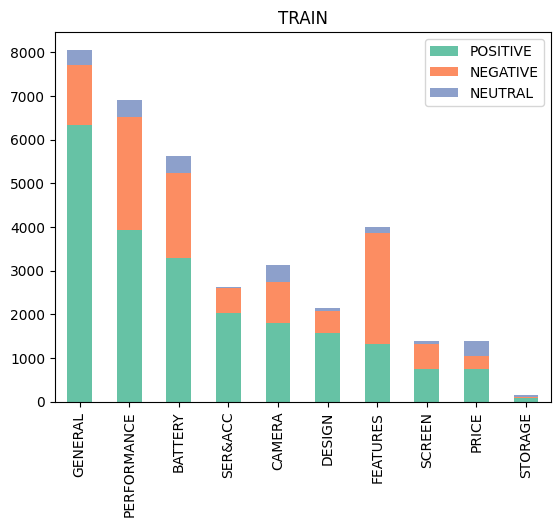

In [ ]:
# Chuyển đổi dữ liệu thành DataFrame
df = pd.DataFrame(merged_list)

# Tạo một từ điển rỗng để lưu trữ số lượng các aspect và sentiment
statistics = {}

# Lặp qua từng mẫu dữ liệu
for index, row in df.iterrows():
    labels = row["labels"]
    if labels:
        for label in labels:
            if isinstance(label, list) and len(label) == 3:
                aspect = label[2].split("#")[0]
                sentiment = label[2].split("#")[1]
                if sentiment not in statistics:
                    statistics[sentiment] = {aspect: 1}
                else:
                    if aspect not in statistics[sentiment]:
                        statistics[sentiment][aspect] = 1
                    else:
                        statistics[sentiment][aspect] += 1

# Chuyển đổi dữ liệu thành DataFrame để vẽ biểu đồ
df_stats = pd.DataFrame(statistics)

# Sắp xếp các cột theo giá trị giảm dần
df_stats.sort_values(by=list(df_stats.columns), ascending=False, inplace=True)

# Tạo bảng màu tùy chỉnh với màu cụ thể cho mỗi cảm xúc
color_palette = {
    "POSITIVE": "#66c2a5",
    "NEGATIVE": "#fc8d62",
    "NEUTRAL": "#8da0cb"
}

# Tạo danh sách màu tương ứng với từng cảm xúc
colors = [color_palette.get(sentiment, "#999999") for sentiment in df_stats.columns]

# Vẽ biểu đồ cột chồng với bảng màu tùy chỉnh
ax = df_stats.plot(kind="bar", stacked=True, color=colors)

# Thiết lập tiêu đề và nhãn trục
plt.title("")
plt.xlabel("")
plt.ylabel("")
#ax.set_ylim(0, 3500)
# Hiển thị biểu đồ
plt.show()


## Tính số lượng nhãn

In [ ]:
# Tính tổng số lượng aspect#sentiment
total_count = 0

for data in merged_list:
    labels = data["labels"]
    if labels:
        total_count += len(labels)

# In tổng số lượng aspect#sentiment
print("Tổng số lượng aspect#sentiment:", total_count)

Tổng số lượng aspect#sentiment: 35396
